In [1]:
import numpy as np
import sys

sys.path.append('../')

from mandala.nodecore import Node
from mandala.nodecore import Variable

from mandala.autodiff import basic_math
from mandala.autodiff import autodiff

In [2]:
def linear_forward(x, W):
    y = np.matmul(x, W.T)
    return y


def linear_backward_W(x, gy):
    gW = np.matmul(gy.T, x)
    return gW


def linear_backward_x(W, gy):
    gx = np.matmul(gy, W)
    return gx


class LinearFunction(autodiff.AutoDiff):

    def forward(self, xs):
        x, W = xs
        y = Node(linear_forward, [x, W])
        return y

    def backward(self, xs, gy):
        x, W = xs
        gW = Node(linear_backward_W, [x, gy])
        gx = Node(linear_backward_x, [W, gy])
        return gx, gW


class Linear(object):
    def __init__(self, in_ch, out_ch):
        self.W = Variable(
            np.random.normal(0, 1 / out_ch, (out_ch, in_ch)).astype('f')
        )

    def __call__(self, x):
        return LinearFunction()([x, self.W])

In [3]:
def sum_forward(x):
    return np.sum(x)


def sum_backward(x, gy):
    return np.ones_like(x) * gy


class SumFunction(autodiff.AutoDiff):
    def forward(self, xs):
        x = xs[0]
        y = Node(sum_forward, [x])
        return y

    def backward(self, xs, gy):
        x = xs[0]
        gx = Node(sum_backward, [x, gy])
        return gx,


def _sum(x):
    return SumFunction()([x])

In [4]:
l0 = Linear( 5, 10)
l1 = Linear(10, 10)
l2 = Linear(10,  3)

In [5]:
# 真の係数
W = np.arange(15, dtype=np.float32).reshape(3, 5)
#W = np.zeros((3, 5), dtype=np.float32)

In [6]:
batchsize = 32
x = Variable(np.random.random((batchsize, 5)).astype(np.float32))
t = Variable(np.matmul(x.data, W.T))

In [7]:
h0 = l0(x)
h1 = l1(h0)
y  = l2(h1)
loss = (y - t) ** 2 / batchsize

In [8]:
loss.backward()

In [9]:
l0.W.grad.data

array([[ 4.7585783 ,  4.24578   ,  5.005123  ,  4.804191  ,  4.0620375 ],
       [ 2.043669  ,  1.8085613 ,  2.1056674 ,  1.9984272 ,  1.6573029 ],
       [ 4.0522537 ,  3.6270928 ,  4.296545  ,  4.14212   ,  3.5274963 ],
       [ 0.872453  ,  0.7852073 ,  0.93842876,  0.9121599 ,  0.7863523 ],
       [ 2.0121179 ,  1.7871281 ,  2.0919988 ,  1.9951582 ,  1.6690402 ],
       [-0.10365281, -0.07276634, -0.05010217, -0.01698005,  0.02892739],
       [-2.460506  , -2.2031617 , -2.6101513 , -2.5161197 , -2.1440535 ],
       [ 0.05014808,  0.05879295,  0.09537687,  0.11458398,  0.12800999],
       [ 7.5837374 ,  6.766343  ,  7.9755173 ,  7.654171  ,  6.4711185 ],
       [ 7.893177  ,  7.0490036 ,  8.319603  ,  7.993449  ,  6.7719564 ]],
      dtype=float32)

In [10]:
lr = 1e-3

for i in range(100):
    # make batch
    x = Variable(np.random.random((batchsize, 5)).astype(np.float32))
    t = Variable(np.matmul(x.data, W.T))
    
    # forward
    h0 = l0(x)
    h1 = l1(h0)
    y  = l2(h1)

    # loss
    loss = _sum((y - t) ** 2) / batchsize
    
    l0.W.grad = 0.
    l1.W.grad = 0.
    l2.W.grad = 0.

    # backward
    loss.backward()
    
    # update
    l0.W.data -= lr * l0.W.grad.data
    l1.W.data -= lr * l1.W.grad.data
    l2.W.data -= lr * l2.W.grad.data

    print(loss.data)

1563.6507568359375
1262.5411376953125
1188.56884765625
1261.85546875
1379.689208984375
1347.88916015625
1225.8448486328125
1157.2578125
1046.1318359375
1280.7882080078125
1323.643798828125
1299.352783203125
1227.9171142578125
1169.3079833984375
1186.92041015625
1122.5927734375
1339.279541015625
1151.46826171875
986.1429443359375
722.918701171875
488.4657287597656
357.0386962890625
153.00970458984375
27.177974700927734
11.58395004272461
3.715667486190796
2.1615307331085205
3.0353965759277344
1.7614834308624268
1.5288848876953125
1.9487735033035278
2.0910398960113525
1.621497631072998
1.5944262742996216
1.3911798000335693
1.3866329193115234
1.1095364093780518
0.8961153030395508
0.9218054413795471
1.5452075004577637
1.3167016506195068
1.5019656419754028
1.8339684009552002
1.2863638401031494
1.4307103157043457
1.303859829902649
0.9715903997421265
1.340451717376709
0.9601355791091919
1.2791824340820312
1.3968924283981323
1.359835147857666
1.0018564462661743
0.919623613357544
1.7442603111267

In [11]:
y.data[0], t.data[0]

(array([ 5.413164, 18.840446, 32.318054], dtype=float32),
 array([ 6.4920135, 19.405428 , 32.31884  ], dtype=float32))

In [12]:
nodes = []

In [13]:
def get_node(y, nodes):
    nodes.append(y)
    for x in y.args:
        if x not in nodes:
            get_node(x, nodes)

In [14]:
l0.W.grad

In [15]:
get_node(l0.W.grad, nodes)
get_node(l1.W.grad, nodes)
get_node(l2.W.grad, nodes)

In [16]:
get_node(loss, nodes)

In [17]:
nodes

In [18]:
import itertools
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(nodes)

In [19]:
for node in nodes:
    for n0, n1 in itertools.permutations(nodes, 2):
        if not n1 in n0.args:
            continue
        if not G.has_edge(n0, n1):
            G.add_edge(n1, n0, weight=1)

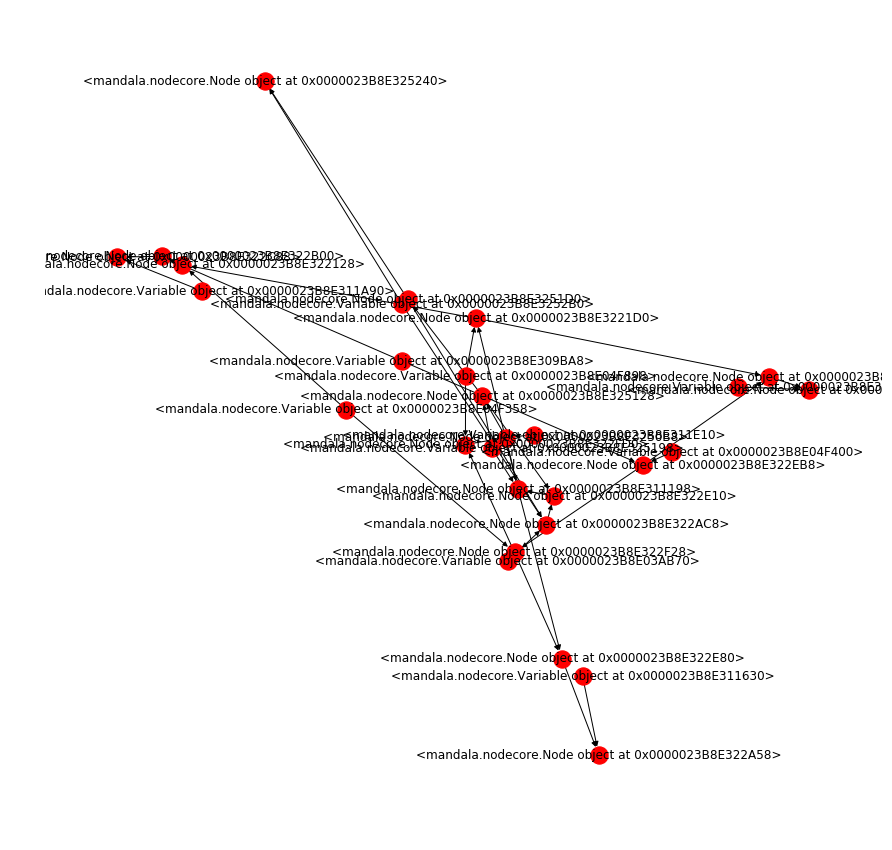

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos)

plt.axis("off")
plt.savefig("default.png")
plt.show()